### Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import random
import os

# Reproducibility
seed = 2
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Optional: disable eager execution (if using graph mode code)
tf.compat.v1.disable_eager_execution()

# Session config
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(config=session_conf)

# Set this session as default for everything that follows
# No set_session needed — use a context manager instead
with sess.as_default():
    # your model/code here
    pass


2025-05-19 13:11:06.456487: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 13:11:06.466288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747660266.476286    3416 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747660266.479144    3416 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747660266.487435    3416 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
import warnings
warnings.filterwarnings('ignore')

from pylab import *

import pandas as pd
import pickle
import time
import sys
import json
import os

# import statsmodels
# import statsmodels.api as sm
# from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, LSTM, GRU, Dropout, TimeDistributed
from keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D 
#from keras.layers.convolutional import Conv1D
#from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping, ProgbarLogger

### Import Classes

In [3]:
os.getcwd()

'/mnt/c/Users/ansel/AppData/Local/Programs/Microsoft VS Code'

In [4]:
os.chdir('/mnt/d/GitHub/WQU-Capstone/notebooks/classes')

os.getcwd()

'/mnt/d/GitHub/WQU-Capstone/notebooks/classes'

In [5]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor, class_ForecastingTrader
%autoreload 1

I0000 00:00:1747660268.855707    3416 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9706 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()
forecasting_trader = class_ForecastingTrader.ForecastingTrader()

Function to evaluate forecasting results:

In [7]:
def evaluate_forecasting(n_pairs, true_values, prediction_values):
    mse, mae, rmse, accuracy, bias = list(), list(), list(), list(), list()
    std_dev = list()
    for i in range(n_pairs):
        mse.append(mean_squared_error(true_values[i], prediction_values[i]))
        rmse.append(np.sqrt(mean_squared_error(true_values[i], prediction_values[i])))
        mae.append(mean_absolute_error(true_values[i], prediction_values[i]))
        accuracy.append(forecasting_trader.calculate_direction_accuracy(true_values[i], prediction_values[i]))
        bias.append((true_values[i] - prediction_values[i]).mean())
        std_dev.append(prediction_values[i].std())
    print('{:.2f}E-4'.format(np.mean(mse)*10000))#Average MSE: 
    print('{:.2f}E-3'.format(np.mean(rmse)*1000))#Average RMSE: 
    print('{:.2f}E-3'.format(np.mean(mae)*1000))#Average RMSE: 
    print('{:.2f}%'.format(np.mean(accuracy)))#Average Directional Accuracy: 
    #print('Bias: {:.2f}E-4'.format(np.mean(bias)*10000))
    #print('Average Standard Deviation from prediction signal ', np.mean(std_dev))
    
    return mse, mae, rmse, accuracy

### MLP

In [8]:
def plot_loss(history, title, epoch_stop, metric='mse'):
    """
    Function to plot loss function.
    Arguments:
    history: History object with data from training.
    title: Plot title.
    """
    plt.figure(figsize=(7,5))
    #plt.grid()
    if metric == 'mse':
        plt.plot(history['loss'], label = "Training MSE")
        plt.plot(history['val_loss'], label = "Validation MSE")
        plt.plot([epoch_stop], [history['val_loss'][epoch_stop]],'o', color='Red', markersize=7)
        plt.annotate(
            'Best Epoch: 41\nValidation MSE:{:.3f}'.format(history['val_loss'][epoch_stop]),
            xy=(epoch_stop, history['val_loss'][epoch_stop]),
            xytext=(-20, 20),
            textcoords='offset points', ha='left', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='grey', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        plt.ylim((0,1.2))
        plt.ylabel('Mean Squared Error', size=12)
    elif metric == 'mae':
        plt.plot(history['mean_absolute_error'], label = "Training MAE")
        plt.plot(history['val_mean_absolute_error'], label = "Validation MAE")
        plt.plot([epoch_stop], [history['val_mean_absolute_error'][epoch_stop]],'o', color='Red', markersize=7)
        plt.annotate(
            'Best Epoch: 41\nValidation MAE:{:.3f}'.format(history['val_mean_absolute_error'][epoch_stop]),
            xy=(epoch_stop, history['val_mean_absolute_error'][epoch_stop]),
            xytext=(-20, 20),
            textcoords='offset points', ha='left', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='grey', alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
        plt.ylim((0,1.2))
        plt.ylabel('Mean Absolute Error', size=12)
    plt.xlabel('Epochs', size=12)
    plt.legend()
    plt.savefig('{}_history.png'.format(metric), bbox='tight')
    
def plot_predictions(summaries):
    
    n_pairs = len(summaries)
    fig, ax = plt.subplots(n_pairs, 1, figsize=(20,25))
    
    for i in range(n_pairs):
        #title('Pair: {}'.format(i))
        predictions = summaries[i]['prediction(t)']
        spread = summaries[i]['spread(t)']
        ax[i].plot(predictions, 'b')
        ax[i].plot(spread, 'r')
    return None

In [9]:
def read_models(path='models/'):
    all_models = [] # Creates an empty list
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".pkl"):
                with open(path+file, 'rb') as f:
                    models = pickle.load(f)
                all_models.append(models)
                
    return all_models

In [10]:
current_path='/mnt/d/GitHub/WQU-Capstone/notebooks/CAE_75etf_17-5-25'
with open(f'{current_path}/cae_5_clusters_pairs_category.pickle', 'rb') as handle: 
    pairs = pickle.load(handle)
len(pairs)

575

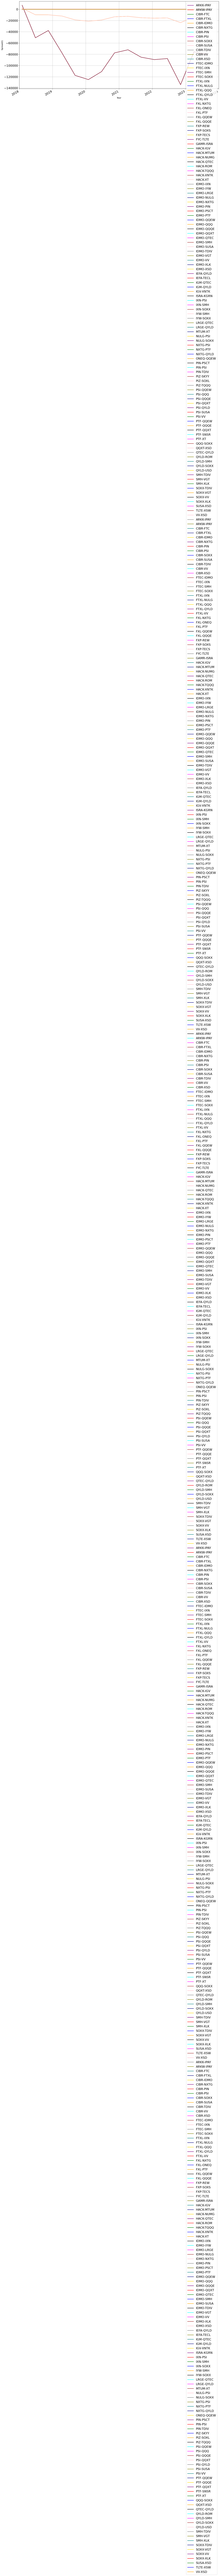

In [11]:
#markers= ["o","s","+","x","<"]
plt.rcParams.update({'font.size': 17})
colors = [
    'purple', 'red', 'green', 'blue', 'orange',
    'black', 'cyan', 'magenta', 'brown', 'pink',
    'gray', 'olive', 'teal', 'navy', 'gold'
]
for i in range(len(pairs)):
    pairs[i][2]['spread'][::100].plot(figsize=(20,10), grid=True, label='{}-{}'.format(pairs[i][0],pairs[i][1]), c=colors[i % len(colors)], linewidth=2)
plt.ylabel('Spread(t)',size=12)
plt.xlabel('Year',size=12)
plt.xlim(('2018', '2024'))
plt.legend()
#plt.savefig('spreads.png', bbox_inches='tight', pad_inches=0.05)

## Training Set

In [12]:
rnn_models = read_models(path=f'{current_path}/models/mlp/') 
#rnn_models

In [13]:
etf_list = pd.read_excel(f'{current_path}/tech_etfs.xlsx')
ticker_segment_dict = dict(zip(etf_list['ticker'], etf_list['name']))
#ticker_segment_dict

In [14]:
# model to test
n_in = 24
hidden_nodes = [50]
low_quantile = 0.10
high_quantile = 0.90
train_val_split = '01-01-2023'

current_path=(f'{current_path}/models/mlp/')

In [15]:
model_rnn, cumret_val, sharperatio_val,summaries_rnn, balance_summaries_rnn = \
            forecasting_trader.run_specific_model(
                                                n_in, 
                                                hidden_nodes, 
                                                pairs,
                                                path=current_path,
                                                train_val_split=train_val_split,
                                                low_quantile=low_quantile, 
                                                high_quantile=high_quantile, 
                                                lag=1,
                                                )

Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not cons

In [16]:
performance_rnn = [(summaries_rnn[i], balance_summaries_rnn[i]) for i in range(len(pairs))]
#performance_rnn

Annual ROI:  0.4041353874883358
39.30434782608695 % of the pairs had positive returns
Not considering risk-free rate
Total number of trades:  1475
Positive trades:  732
Negative trades:  743
Total Drawdown Days: 123 days
Max DD period: 1 days
Maximum drawdown of portfolio: -0.26%


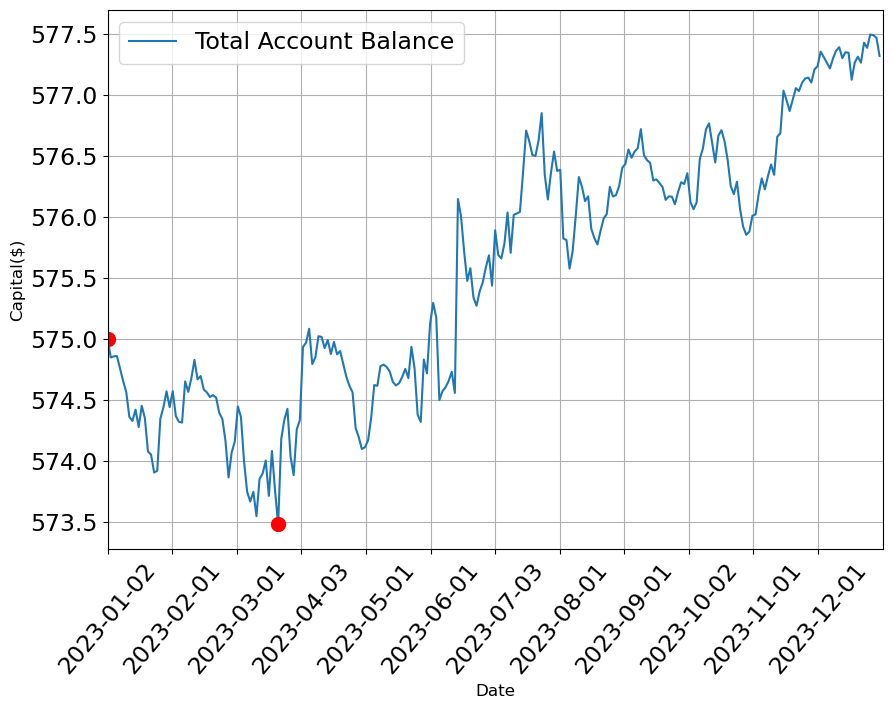

In [17]:
results, pairs_summary = trader.summarize_results(sharperatio_val,
                                                  cumret_val,
                                                  performance_rnn,
                                                  pairs, ticker_segment_dict,
                                                  n_years=1)

In [18]:
results

{'n_pairs': 575,
 'portfolio_sharpe_ratio': np.float64(0.722039121216501),
 'avg_total_roi': np.float64(0.4041353874883333),
 'avg_annual_roi': np.float64(0.4041353874883358),
 'pct_positive_trades_per_pair': np.float64(54.4656615214902),
 'pct_pairs_with_positive_results': 39.30434782608695,
 'avg_half_life': np.float64(34.504347826086956),
 'avg_hurst_exponent': np.float64(0.38037784174744244)}

Training:

In [19]:
init = model_rnn[0]['predictions_train'].index[0]
true_train = [pairs[i][2]['spread'][init:train_val_split] for i in range(len(pairs))]
predictions_train = [model_rnn[i]['predictions_train'] for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), true_train, predictions_train)

2125095176.80E-4
50223.63E-3
34089.09E-3
51.61%


Validation:

In [20]:
true_val = [summaries_rnn[i]['spread(t)'] for i in range(len(pairs))]
predictions = [summaries_rnn[i]['prediction(t)'] for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), true_val, predictions)

930641377.37E-4
33772.21E-3
26743.17E-3
49.13%


## **Test unrestricted**

In [21]:
model_rnn, cumret_test, sharperatio_test, summaries_rnn, balance_summaries_rnn = \
        forecasting_trader.test_specific_model(
                n_in, 
                hidden_nodes, 
                pairs, 
                path=current_path,
                low_quantile=low_quantile, 
                high_quantile=high_quantile, 
                lag=1, 
                profitable_pairs_indices=range(len(pairs))
                )
performance_rnn = [(summaries_rnn[i], balance_summaries_rnn[i]) for i in range(len(pairs))]
#performance_rnn 

Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not cons

Annual ROI:  -2.445950604593894
35.82608695652174 % of the pairs had positive returns
Not considering risk-free rate
Total number of trades:  3933
Positive trades:  1721
Negative trades:  2212
Total Drawdown Days: 141 days
Max DD period: 3 days
Maximum drawdown of portfolio: -2.67%


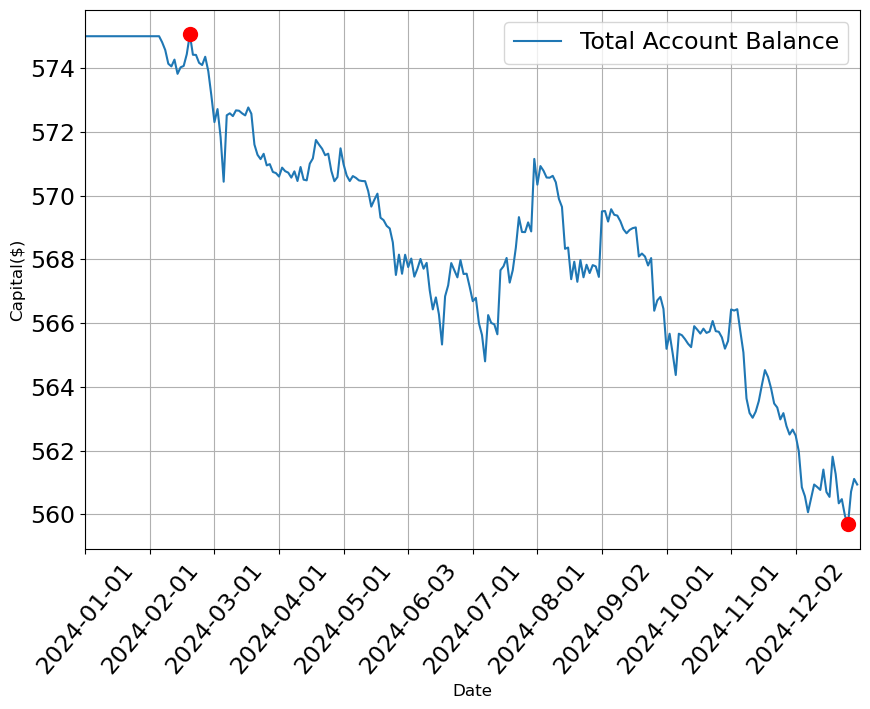

In [22]:
results, pairs_summary = trader.summarize_results(sharperatio_test,
                                                  cumret_test,
                                                  performance_rnn,
                                                  pairs, ticker_segment_dict,
                                                  n_years=1)

In [23]:
results

{'n_pairs': 575,
 'portfolio_sharpe_ratio': np.float64(-1.447439510923338),
 'avg_total_roi': np.float64(-2.4459506045938904),
 'avg_annual_roi': np.float64(-2.445950604593894),
 'pct_positive_trades_per_pair': np.float64(44.10168128536383),
 'pct_pairs_with_positive_results': 35.82608695652174,
 'avg_half_life': np.float64(34.504347826086956),
 'avg_hurst_exponent': np.float64(0.3803778417474425)}

In [24]:
#pairs_summary 

Test:

In [25]:
true_test = [summaries_rnn[i]['spread(t)'] for i in range(len(pairs))]
predictions = [summaries_rnn[i]['prediction(t)'] for i in range(len(pairs))]
_ = evaluate_forecasting(len(pairs), true_test, predictions)

1208665989.64E-4
38885.20E-3
29867.95E-3
46.45%


## **Test with active pairs on validation set**

In [26]:
cumret_val = np.asarray(cumret_val)
profitable_pairs_indices = np.argwhere(cumret_val > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]
model_rnn, cumret_test, sharperatio_test, summaries_rnn, balance_summaries_rnn = \
        forecasting_trader.test_specific_model(n_in, hidden_nodes, pairs, path=current_path,
                                               low_quantile=low_quantile, high_quantile=high_quantile, lag=1, 
                                               profitable_pairs_indices=profitable_pairs_indices)
performance_rnn = [(summaries_rnn[i], balance_summaries_rnn[i]) for i in range(len(profitable_pairs))]
#performance_rnn

Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not considering risk-free rate
Not cons

Annual ROI:  -2.07515694768845
40.26548672566372 % of the pairs had positive returns
Not considering risk-free rate
Total number of trades:  1876
Positive trades:  850
Negative trades:  1026
Total Drawdown Days: 137 days
Max DD period: 1 days
Maximum drawdown of portfolio: -2.87%


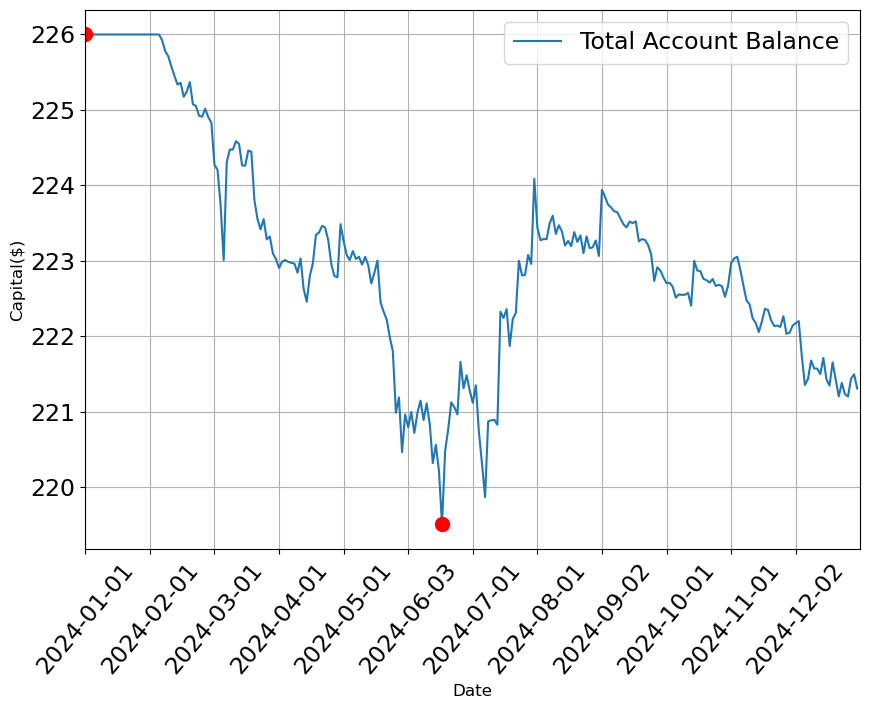

In [27]:
results, pairs_summary = trader.summarize_results(sharperatio_test,
                                                  cumret_test,
                                                  performance_rnn,
                                                  profitable_pairs, ticker_segment_dict,
                                                  n_years=1)                                                

In [28]:
results  

{'n_pairs': 226,
 'portfolio_sharpe_ratio': np.float64(-0.937705747514905),
 'avg_total_roi': np.float64(-2.0751569476884537),
 'avg_annual_roi': np.float64(-2.07515694768845),
 'pct_positive_trades_per_pair': np.float64(44.069099666124),
 'pct_pairs_with_positive_results': 40.26548672566372,
 'avg_half_life': np.float64(33.18141592920354),
 'avg_hurst_exponent': np.float64(0.37313640693164907)}

In [29]:
#pairs_summary